# CS470 Introduction to Artificial Intelligence
## Deep Learning Practice 
#### TA. Minho Sim


---

## 2-3. Overfitting and how to fight it

#### Topics for this chapter
 * Overfitting
 * Early stop
 * Adjusting parameter size 
 * Regularization
 * Dropout
 ---

In the previous example, we saw that the accuracy of our model on the validation data peaked after training for a few number of epochs, and then started decreasing or being fixed.

In other words, our model was **overfitted to the training data**. <br/><br/>


#### Overfitting
  _Achieves very low training error, but very high test error (not generalized to unseen examples)_

<br/>

Learning how to deal with overfitting is very important. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop **models that generalize well to a testing set** (or data they haven't seen before).

Training the model is similar to preparing for the exam. When we prepare the exam, we often refer to past problems. However, the purpose of studying past problems is not just to solve them well. It is to solve upcoming problems well by studying patterns in past problems. Therefore memorizing past problems' answers to solve them will not help for the upcoming exams at all. The same goes for training the model. Just memorizing training data will not improve the accuracy for the unseen data. 

If we train the model too long, the model will start to overfit and learn patterns from the training data and eventually we get the model that doesn't generalize to the unseen data. We need to keep balance well between training data and test data. Understanding how can we choose an appropriate number of training epochs can be an useful skill. We call it **early stopping** (stop training before overfitting).

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/earlystop.png?raw=true"  width="800">

               Slide credit: © MIT 6.S191: Introduction to Deep Learning

<br/><br/>

There are many solutions to prevent overfitting and the best solution is to increase the training data. A model trained on many data will naturally generalize well (high accuracy for unseen data). If it is impossible to collect a large amount of training dataset, the next possible solution is to use techniques like **regularization**. Regularization imposes constraints on the quantity and type of information a model can store. If a network can only afford to memorize a small number of patterns, not the whole train data, the optimization process will force it to focus on the most prominent patterns, which will lead to a better chance of generalizing well.

In this part, we'll explore two common regularization techniques, `weight regularization` and `dropout`, and use them to improve our model.

First, we'll set up the environment as before.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

Tensorflow:  2.6.0


#### Load the IMDB dataset

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

In [3]:
train_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

#### Create a validation set

In [4]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### Demonstrate overfitting by various model size

A simple way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model. In deep learning, the number of learnable parameters in a model is often referred to as the model's **_capacity_**. Intuitively, a model with more parameters will have more memorization capacity and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their labels. **Note that a mapping without any generalization power is useless when making predictions on previously unseen data**.

On the other hand, if the network has a low capacity and limited memorization resources, it will not be able to learn the mapping as easily. Instead, in order to minimize its loss, **it will have to learn compressed representations that have more predictive power.** At the same time, if you make your model too small, **it will have difficulty fitting to the training data.** We need a balance between "too much capacity" and "not enough capacity".

To find an appropriate model size empirically, it's good to start with relatively few layers and parameters and then start increasing the number of layers until you see performance decline by checking the validation loss or accuracy. Let's try this approach on our movie review classification network.

First, we'll create a simple model using only Dense layers as a baseline. And then we will create smaller and larger versions, and compare them.

#### Create a baseline model

In [5]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', 
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
baseline_history = baseline_model.fit(partial_x_train,
                                      partial_y_train,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(x_val, y_val),
                                      verbose=2)

Epoch 1/20
30/30 - 2s - loss: 0.5807 - accuracy: 0.7410 - val_loss: 0.4394 - val_accuracy: 0.8488
Epoch 2/20
30/30 - 0s - loss: 0.3296 - accuracy: 0.8935 - val_loss: 0.3111 - val_accuracy: 0.8819
Epoch 3/20
30/30 - 0s - loss: 0.2218 - accuracy: 0.9273 - val_loss: 0.2813 - val_accuracy: 0.8898
Epoch 4/20
30/30 - 0s - loss: 0.1679 - accuracy: 0.9482 - val_loss: 0.2782 - val_accuracy: 0.8881
Epoch 5/20
30/30 - 0s - loss: 0.1312 - accuracy: 0.9626 - val_loss: 0.2859 - val_accuracy: 0.8844
Epoch 6/20
30/30 - 0s - loss: 0.1045 - accuracy: 0.9720 - val_loss: 0.3009 - val_accuracy: 0.8835
Epoch 7/20
30/30 - 0s - loss: 0.0841 - accuracy: 0.9795 - val_loss: 0.3204 - val_accuracy: 0.8806
Epoch 8/20
30/30 - 0s - loss: 0.0662 - accuracy: 0.9869 - val_loss: 0.3421 - val_accuracy: 0.8793
Epoch 9/20
30/30 - 0s - loss: 0.0524 - accuracy: 0.9909 - val_loss: 0.3659 - val_accuracy: 0.8779
Epoch 10/20
30/30 - 0s - loss: 0.0415 - accuracy: 0.9940 - val_loss: 0.3966 - val_accuracy: 0.8736
Epoch 11/20
30/30 -

#### Create a smaller model
Let's create a model with less hidden units to compare against the baseline model that we just created:

In [7]:
smaller_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam', 
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [8]:
smaller_history = smaller_model.fit(partial_x_train,
                                    partial_y_train,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(x_val, y_val),
                                    verbose=2)

Epoch 1/20
30/30 - 1s - loss: 0.6368 - accuracy: 0.6529 - val_loss: 0.5769 - val_accuracy: 0.7531
Epoch 2/20
30/30 - 0s - loss: 0.5238 - accuracy: 0.7963 - val_loss: 0.5189 - val_accuracy: 0.8160
Epoch 3/20
30/30 - 0s - loss: 0.4687 - accuracy: 0.8633 - val_loss: 0.4919 - val_accuracy: 0.8349
Epoch 4/20
30/30 - 0s - loss: 0.4311 - accuracy: 0.8987 - val_loss: 0.4773 - val_accuracy: 0.8425
Epoch 5/20
30/30 - 0s - loss: 0.4019 - accuracy: 0.9216 - val_loss: 0.4633 - val_accuracy: 0.8629
Epoch 6/20
30/30 - 0s - loss: 0.3794 - accuracy: 0.9378 - val_loss: 0.4608 - val_accuracy: 0.8562
Epoch 7/20
30/30 - 0s - loss: 0.3595 - accuracy: 0.9509 - val_loss: 0.4616 - val_accuracy: 0.8549
Epoch 8/20
30/30 - 0s - loss: 0.3421 - accuracy: 0.9605 - val_loss: 0.4529 - val_accuracy: 0.8665
Epoch 9/20
30/30 - 0s - loss: 0.3276 - accuracy: 0.9667 - val_loss: 0.4563 - val_accuracy: 0.8627
Epoch 10/20
30/30 - 0s - loss: 0.3138 - accuracy: 0.9739 - val_loss: 0.4563 - val_accuracy: 0.8638
Epoch 11/20
30/30 -

#### Create a bigger model
In this section, let's create an even larger model and see how quickly it begins overfitting.

In [9]:
bigger_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam', 
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [10]:
bigger_history = bigger_model.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(x_val, y_val),
                                  verbose=2)

Epoch 1/20
30/30 - 1s - loss: 0.3892 - accuracy: 0.8337 - val_loss: 0.2801 - val_accuracy: 0.8862
Epoch 2/20
30/30 - 0s - loss: 0.1347 - accuracy: 0.9521 - val_loss: 0.3353 - val_accuracy: 0.8788
Epoch 3/20
30/30 - 0s - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.4286 - val_accuracy: 0.8765
Epoch 4/20
30/30 - 0s - loss: 0.0078 - accuracy: 0.9991 - val_loss: 0.5430 - val_accuracy: 0.8749
Epoch 5/20
30/30 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6168 - val_accuracy: 0.8766
Epoch 6/20
30/30 - 0s - loss: 4.6797e-04 - accuracy: 1.0000 - val_loss: 0.6654 - val_accuracy: 0.8761
Epoch 7/20
30/30 - 0s - loss: 2.6649e-04 - accuracy: 1.0000 - val_loss: 0.6946 - val_accuracy: 0.8771
Epoch 8/20
30/30 - 0s - loss: 1.8362e-04 - accuracy: 1.0000 - val_loss: 0.7162 - val_accuracy: 0.8772
Epoch 9/20
30/30 - 0s - loss: 1.3633e-04 - accuracy: 1.0000 - val_loss: 0.7341 - val_accuracy: 0.8766
Epoch 10/20
30/30 - 0s - loss: 1.0633e-04 - accuracy: 1.0000 - val_loss: 0.7500 - val_accuracy: 0.8768

#### Plot the training and validation loss

In [11]:
history_dict = baseline_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [12]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
        
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    
    plt.xlim([0,max(history.epoch)])

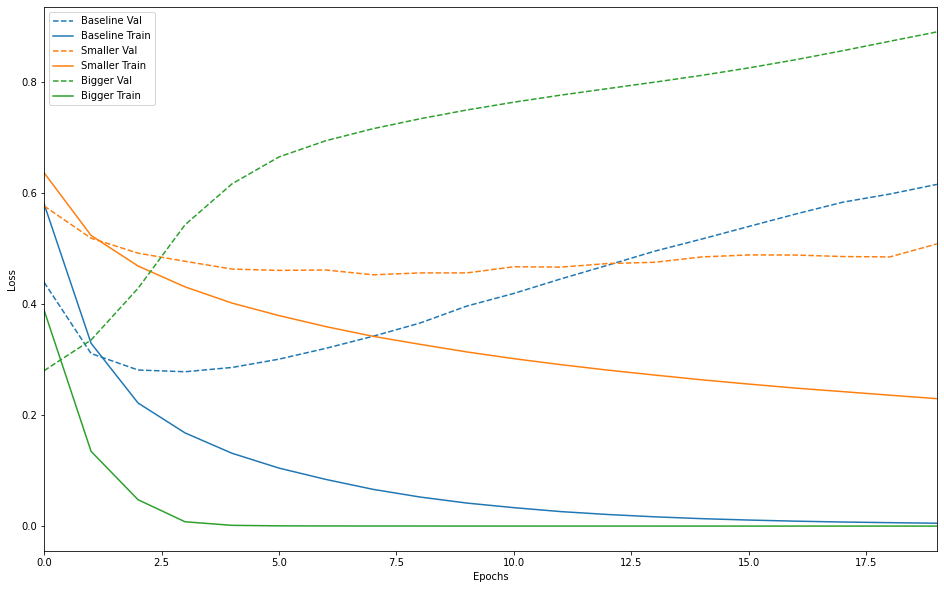

In [13]:
plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model). Here, the smaller network begins overfitting later (after more than 8 epochs) than the baseline model (start overfitting after about 3 epochs) and its performance degrades much more slowly once it starts overfitting.

You can see that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. **The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss)**. But we have to be suspicious whether it is overfitted or not (resulting in a large difference between the training and validation loss).

<br/><br/>

#### Solution 1: Add weight regularization

Given some training data and a network architecture, there are multiple sets of weights values (multiple models) that can explain the data, and simpler models are less likely to overfit than complex ones. A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). 

One powerful way to mitigate overfitting is to **put constraints on the complexity of a network by forcing its weights only to take small values**, which leads to the distribution of weight values more regular. This is called **_weight regularization_**, and it is done by adding a cost term associated with weights of the model to the loss function of the network. With this added term, now the model has to minimize not just loss function and it has to balance model complexity and loss function simultaneously.

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/regularization.png?raw=true"  width="800">

Here, large weighting parameter will make the model with smaller weights and small weighting parameter will make the model parameters free which will lead to complex model.

This cost comes in two flavors:

 - [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the **absolute value** of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/l1.png?raw=true"  width="400">

 - [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the **square of the value** of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks.
 
<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/l2.png?raw=true"  width="400">
 
In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [14]:
l2_model = tf.keras.Sequential([
    # TODO: add a first dense layer with 16 nodes applying ReLU activation function 
    #                   with L2 regularization term  (tf.keras.regularizers.l2)
    
    
    # TODO: add a second dense layer with 16 nodes applying ReLU activation function
    #                   with L2 regularization term 

    
    # TODO: add a last dense layer with only 1 node applying Softmax activation function
])

l2_model.compile(optimizer='adam', 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

l2_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

Now let's see the effect of adding L2 regularization penalty:

In [ ]:
# Train the l2 model with partial training data and validation data we made 
l2_model_history = l2_model.fit(partial_x_train,
                                partial_y_train,
                                epochs=20,
                                batch_size=512,
                                validation_data=(x_val, y_val),
                                verbose=2)

In [ ]:
plot_history([('bigger', bigger_history),
              ('l2', l2_model_history)])

As you can see, the L2 regularized model has become much more resistant to overfitting than the bigger model when trained too long.

<br/><br/>

#### Solution 2: Add dropout

Dropout is one of the most effective and commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, you roll a dice to decide whether to include a node in training.

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/dice.png?raw=true"  width="500">

               Slide credit: KAIST CS576 : Computer Vision (Seunghoon Hong)
<br/>

Randomly turn off activations with some probability _p_
 * Intuition: add stochasticity to the network to prevent memorization (every forward propagation leads to different outputs even for the same input)

<br/>

The `dropout rate` is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. Dropout will randomly turn off activations with the probability `dropout rate`.


At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate. (We do not have to implement this action since `tf.Dropout` will do these operations by itself.)

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/dropout2.png?raw=true"  width="500">

Training neural nets with dropout has the same effect as **training multiple networks with ensemble**. If we assume that there are N units in the original neural net, then the number of possible networks is 2^N. So we have the approximately same effect as ensembling all these 2^N networks together.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our IMDB network to see how well they do at reducing overfitting:

In [ ]:
dp_model = tf.keras.Sequential([
    # TODO: add a first dense layer with 16 nodes applying ReLU activation function 
    
    # TODO: add a dropout layer with 0.5 dropout rate
    
    # TODO: add a second dense layer with 16 nodes applying ReLU activation function
    
    # TODO: add a dropout layer with 0.5 dropout rate
    
    # TODO: add a last dense layer with only 1 node applying Softmax activation function
])

dp_model.compile(optimizer='adam', 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

dp_model.summary()

In [ ]:
# Train the dropout model with partial training data and validation data we made 

dp_model_history = dp_model.fit(partial_x_train,
                                partial_y_train,
                                epochs=20,
                                batch_size=512,
                                validation_data=(x_val, y_val),
                                verbose=2)

In [ ]:
plot_history([('baseline', baseline_history),
              ('dropout', dp_model_history)])

Also, we can check the effect of dropout by drawing a graph of the accuracies for both models.

In [ ]:
plot_history([('baseline', baseline_history),
              ('dropout', dp_model_history)],key='accuracy')

Here the validation accuracy is higher when dropout is applied to the model. Adding dropout made a clear improvement over the baseline model.

To recap: here the most common ways to prevent overfitting in neural networks:

- Early stopping before overfitting.
- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.

And two important approaches not covered in this guide are data-augmentation and batch normalization.